# Climate Data Store (CDS) -  Backend


Copernicus Climate Change Service (C3S) - Upper Air Data Service

This IPython Notebook is intended for demonstration purposes and example usage of the Climate Data Store (CDS) Backend for Radiosonde data.

For further information please refer to the Deliverable Document on [Github CEUAS](https://github.com/MBlaschek/CEUAS/tree/master/CEUAS/public/cds-backend).


    Author: M. Blaschek
    Date: 01.2020
    Contact: michael.blaschek [at] univie.ac.at
    

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plotting parameters
plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.style.use('seaborn-colorblind')

In [3]:
#
# Make sure you have Python 3
#
from platform import python_version
if python_version()[0] != '3':
    print("Your Version:", python_version())
    raise RuntimeError("This Notebook requires Python 3")

# Functionality of the delivering server
The delivered server allows to respond to post requests and delivers the requested data in a compressed format (zip).
The interface can be a pure python code or via a linux shell.

## Python version

A typical request should contain:
1. **statid** - the Station Identifier
2. **date** - datetime selection YYYYMMDD
3. **pressure_level** - selection of pressure levels
4. **variable** - selection of variables 
5. **fbstats**  - feedback information from reanalysis

In [83]:
import requests, zipfile, io, os
#
# This is for Python 3+
#
# http://early-upper-air.copernicus-climate.eu
r = requests.post('http://srvx8.img.univie.ac.at:8004',
                  headers={'content-type': 'application/json'},
                  json={"statid": "10393",
                        "date": [20000101, 20000101],
                        "pressure_level": [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000,
                                           50000, 70000, 85000, 92500, 100000],
                        "variable": ["temperature", "relative_humidity"],
                        "fbstats": ["obs_minus_bg", "obs_minus_an", "bias_estimate"]
                        },
                  stream=True)

if "Administrator" in r.text:
    print(r.text)
    raise RuntimeError("Something is not correct with the request")
#
# Create directory
#
if not os.path.isdir('./example_data'):
    os.makedirs('./example_data')
#
# Unzip the Data Stream
#
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Retreived files: ")
print(z.namelist())

z.extractall(path='./example_data')

Retreived files: 
['dest_10393_air_temperature.nc', 'dest_10393_relative_humidity.nc']


## Shell command

Another Way can be use a Linux tool called `curl` to download a zipfile:

```bash
curl -H "Content-Type: application/json" -X POST --digest --data '{"statid":"10393","date":[20000101,20181231],"pressure_level":[1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000],"variable":["temperature","relative_humidity"],"fbstats":["obs_minus_bg","obs_minus_an","bias_estimate"]}' -o example_data/download.zip http://srvx8.img.univie.ac.at:8004
```

and then unzip the contents in the directory

```bash
unzip -o example_data/download.zip
```

In [88]:
# Show the new downloaded files in example_data directory
!tree -Dhr

.
├── [1.0K Jan 15 17:01]  README.md
├── [ 33K Jan 23 16:04]  raso_adj_cdm_v0.py
├── [245K Jan 23 16:24]  Example_Homogenization.ipynb
└── [  80 Jan 22  9:51]  example_data
    ├── [8.5M Jan 23 16:21]  dest_10393_relative_humidity.nc
    └── [8.5M Jan 23 16:21]  dest_10393_air_temperature.nc

1 directory, 5 files


## NCDUMP

In [89]:
# Example output of retrieved NetCDF file
!ncdump -h example_data/dest_10393_air_temperature.nc

netcdf dest_10393_air_temperature {
dimensions:
	obs = 530917 ;
	string5 = 5 ;
	trajectory = 27931 ;
variables:
	float bias_estimate(obs) ;
		bias_estimate:cdmname = "era5fb/biascorr@body" ;
		bias_estimate:units = "K" ;
		bias_estimate:coordinates = "lat lon time plev" ;
		bias_estimate:cdsname = "bias_estimate" ;
		bias_estimate:standard_name = "air_temperature" ;
		bias_estimate:long_name = "ERA5 reanalysis bias_estimate" ;
	float lat(obs) ;
		lat:cdmname = "observations_table/latitude" ;
		lat:units = "degree_north" ;
		lat:standard_name = "latitude" ;
	float lon(obs) ;
		lon:cdmname = "observations_table/longitude" ;
		lon:units = "degree_east" ;
		lon:standard_name = "longitude" ;
	float obs_minus_an(obs) ;
		obs_minus_an:cdmname = "era5fb/an_depar@body" ;
		obs_minus_an:units = "K" ;
		obs_minus_an:coordinates = "lat lon time plev" ;
		obs_minus_an:cdsname = "obs_minus_an" ;
		obs_minus_an:standard_name = "air_temperature" ;
		obs_minus_an:long_name = "ERA5 reanalysis obs_minus_

# Request a profile

# Request a timeseries

# Request multiple Stations

# Request ??

In [90]:
import xarray as xr

In [91]:
ident = '10393'  # Station Identifier

In [92]:
tdata = xr.load_dataset('example_data/dest_{}_air_temperature.nc'.format(ident))

In [93]:
rdata = xr.load_dataset('example_data/dest_{}_relative_humidity.nc'.format(ident))

## Temperature data in Xarray

Notice that there are the following variables:
* bias_estimate - Reanalysis Bias estimate
* obs_min_an - Analysis Departures
* obs_min_bg - First Guess Departures
* ta - Observations
* trajectory_index - CDM Identifier
* trajectory_label - CDM Identifier

In [94]:
tdata

<xarray.Dataset>
Dimensions:           (obs: 530917, trajectory: 27931)
Coordinates:
    lat               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    lon               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    plev              (obs) float32 2000.0 3000.0 5000.0 ... 92500.0 100000.0
    time              (obs) datetime64[ns] 2000-01-01T05:00:00 ... 2018-12-31T22:45:38
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 -0.08317 -0.048345 -0.070816 ... 0.00375 0.0
    obs_minus_an      (obs) float32 0.297017 0.598117 ... 0.20772 -0.036169
    obs_minus_bg      (obs) float32 0.733175 0.495885 ... -0.338893 0.347498
    ta                (obs) float32 201.7 203.1 207.1 ... 274.61 277.48 279.37
    trajectory_index  (obs) int32 0 0 0 0 0 0 ... 27930 27930 27930 27930 27930
    trajectory_label  (trajectory) |S5 b'11865' b'11866' ... b'39817' b'39818'
Attributes:
    primary_id:    0-20000-0-10393
    sta

## Relative humidity 

In [95]:
rdata

<xarray.Dataset>
Dimensions:           (obs: 530917, trajectory: 27931)
Coordinates:
    lat               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    lon               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    plev              (obs) float32 2000.0 3000.0 5000.0 ... 92500.0 100000.0
    time              (obs) datetime64[ns] 2000-01-01T05:00:00 ... 2018-12-31T22:45:38
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    hur               (obs) float32 nan nan nan nan ... 0.952928 1.0 1.0
    obs_minus_an      (obs) float32 nan nan nan ... -0.044241 0.022678 0.000384
    obs_minus_bg      (obs) float32 nan nan nan nan ... -0.026135 0.070745 8e-06
    trajectory_index  (obs) int32 0 0 0 0 0 0 ... 27930 27930 27930 27930 27930
    trajectory_label  (trajectory) |S5 b'11865' b'11866' ... b'39817' b'39818'
Attributes:
    primary_id:    0-20000-0-10393
    st

## Plotting

Text(0.5, 1.0, 'Radiosonde Temperature Observations from 10393 at 500 hPa')

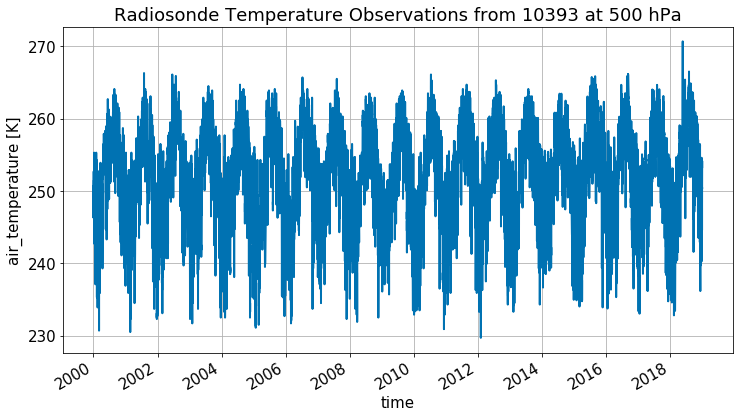

In [96]:
tdata.ta.sel(obs=(tdata.plev==50000)).swap_dims({'obs':'time'}).plot()
grid()
title("Radiosonde Temperature Observations from {} at 500 hPa".format(ident))

Text(0.5, 1.0, 'Radiosonde relative humidity Observations from 10393 at 500 hPa')

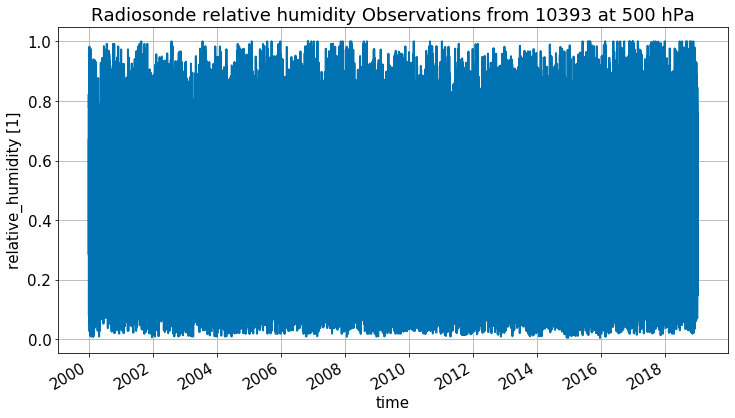

In [97]:
rdata.hur.sel(obs=(rdata.plev==50000)).swap_dims({'obs':'time'}).plot()
grid()
title("Radiosonde relative humidity Observations from {} at 500 hPa".format(ident))